In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action="ignore")

import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
plt.rc("font", family=font_name)

import matplotlib as mpl
mpl.rcParams["axes.unicode_minus"] = False

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 예산 데이터가 없는 영화 데이터

## 1. 데이터 불러오기

In [2]:
movie_one_hot = pd.read_csv('../data/Preprocessing_movie_data/final_data.csv', parse_dates=['openingdate'])

In [3]:
movie_one_hot.head()

,moviename,openingdate,attendance,screen,playcount,director,actor,openingmonth,country_abroad,country_domestic,...,genre_fear,genre_mystery,genre_romance,genre_sf,genre_thriller,filmrank_G_rated,filmrank_PG 12,filmrank_PG 15,filmrank_X_rated,sales
0,극한직업,2019-01-23,16265618,2003,292584,6834886,3,1,0,1,...,0,0,0,0,0,0,0,1,0,139651845516
1,명량,2014-07-30,17613682,1587,188611,8982706,3,7,0,1,...,0,0,0,0,0,0,1,0,0,135748398910
2,어벤져스: 엔드게임,2019-04-24,13934592,2835,242001,10224854,3,4,1,0,...,0,0,0,0,0,0,1,0,0,122182694160
3,베테랑,2015-08-05,13414009,1115,199231,7576385,3,8,0,1,...,0,0,0,0,0,0,0,1,0,105168155250
4,신과함께-인과 연,2018-08-01,12274996,2235,179981,6491963,3,8,0,1,...,0,0,0,0,0,0,1,0,0,102666146909


In [4]:
movie_filmrank_list = ['g', '15', 'x', '12']
movie_filmranks = []
for path in movie_filmrank_list:
    movie_filmranks.append(pd.read_csv('../data/Preprocessing_movie_data/movie_filmrank_'+path+'.csv',
                          parse_dates=['openingdate']))

### 2. Regression

#### 2-1 category : filmrank

In [5]:
movie_filmranks[0].columns

Index(['moviename', 'openingdate', 'sales', 'attendance', 'screen',
       'playcount', 'country', 'country_label', 'distributor',
       'distributor_label', 'director', 'genre', 'genre_label', 'actor',
       'openingmonth'],
      dtype='object')

In [6]:
col = ['sales', 'attendance', 'screen', 'playcount', 'country',
       'distributor', 'director', 'genre', 'actor', 'openingmonth']
one_hot_col = ['country', 'distributor', 'genre']
filmrank_one_hot = []
for filmrank in movie_filmranks:
    filmrank = filmrank[col]
    one_hot = pd.get_dummies(filmrank, columns=one_hot_col)
    filmrank_one_hot.append(one_hot)

for rank in filmrank_one_hot:
    print(rank.shape)

(186, 19)
(398, 25)
(120, 22)
(317, 25)


In [7]:
x = []
y = []
for rank in filmrank_one_hot:
    x.append(rank.iloc[:, 1:])
    y.append(rank.iloc[:, 0].to_numpy())

for i in range(len(x)):
    print(x[i].head())
    print(y[i][:5])

   attendance  screen  playcount  director  actor  openingmonth  \
0    10296101    1010     157683   5337414      2             1   
1     5062720     948     101338   4523766      6             5   
2     4743264    1936     126496   3141537      3             7   
3     4969735     931      84000   4969735      3             7   
4     4706158     735     131005   4706158      3             2   

   country_abroad  country_domestic  distributor_etc_distributor  \
0               1                 0                            0   
1               1                 0                            0   
2               1                 0                            0   
3               1                 0                            0   
4               1                 0                            0   

   distributor_major_abroad  distributor_major_domestic  genre_action  \
0                         1                           0             0   
1                         0               

In [8]:
for i in range(len(x)):
    sc = MinMaxScaler()
    sc.fit(x[i])
    x_scale = sc.transform(x[i])
    x[i] = pd.DataFrame(data=x_scale, columns=x[i].columns.tolist())

In [9]:
data = []
for i in range(len(x)):
    x_train, x_test, y_train, y_test = train_test_split(x[i], y[i], random_state=42)
    data.append([x_train, x_test, y_train, y_test])

In [10]:
def build_model(input_shape):
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=(input_shape,)),
        layers.Dense(256, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.1)
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse'])
    
    return model

In [11]:
models = []
for i in range(len(data)):
    models.append(build_model(len(data[i][0].columns)))
    models[i].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4864      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 202,497
Trainable params: 202,497
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
____________________________

In [12]:
epochs = 2000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

histories = []

for i in range(len(data)):
    history = models[i].fit(
        data[i][0], data[i][2],
        epochs=epochs, validation_split=0.2, verbose=0,
        callbacks=[early_stop]
    )
    histories.append(history)

In [13]:
histes = []
for i in range(len(models)):
    hist = pd.DataFrame(histories[i].history)
    hist['epoch'] = histories[i].epoch
    print(hist.tail())
    histes.append(hist)

            loss           mae           mse      val_loss       val_mae  \
60  2.504606e+18  1.167594e+09  2.504606e+18  3.007405e+18  1.102359e+09   
61  2.220699e+18  9.844265e+08  2.220699e+18  3.108508e+18  1.145557e+09   
62  2.318280e+18  9.316904e+08  2.318280e+18  2.623297e+18  1.021215e+09   
63  2.819663e+18  1.076941e+09  2.819663e+18  3.424763e+18  1.159249e+09   
64  2.004552e+18  1.084324e+09  2.004552e+18  3.299833e+18  1.348975e+09   

         val_mse  epoch  
60  3.007405e+18     60  
61  3.108508e+18     61  
62  2.623297e+18     62  
63  3.424763e+18     63  
64  3.299833e+18     64  
            loss           mae           mse      val_loss       val_mae  \
88  1.882313e+18  9.442845e+08  1.882313e+18  3.301177e+18  1.374274e+09   
89  3.283985e+18  1.219995e+09  3.283985e+18  5.219651e+18  1.854605e+09   
90  2.416592e+18  1.162646e+09  2.416592e+18  3.309482e+18  1.317793e+09   
91  2.919952e+18  1.138631e+09  2.919952e+18  2.533498e+18  1.376700e+09   
92  1.8

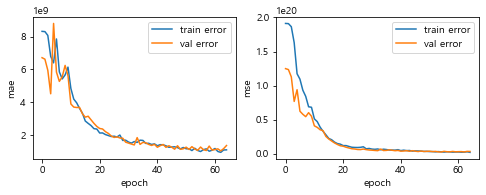

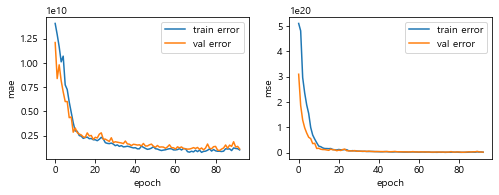

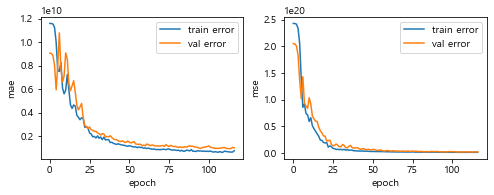

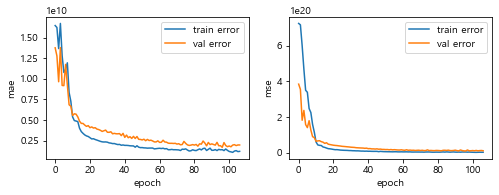

In [14]:
cnt = 1
for i in range(len(models)):
    plt.figure(figsize=(8, 12))

    plt.subplot(4, 2, cnt)
    plt.xlabel('epoch')
    plt.ylabel('mae')
    plt.plot(histes[i]['epoch'], histes[i]['mae'], label='train error')
    plt.plot(histes[i]['epoch'], histes[i]['val_mae'], label='val error')
    plt.legend()

    plt.subplot(4, 2, cnt+1)
    plt.xlabel('epoch')
    plt.ylabel('mse')
    plt.plot(histes[i]['epoch'], histes[i]['mse'], label='train error')
    plt.plot(histes[i]['epoch'], histes[i]['val_mse'], label='val error')
    plt.legend()
    
    cnt += 2

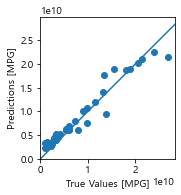

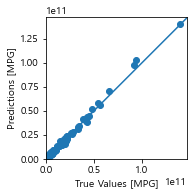

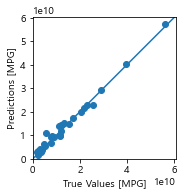

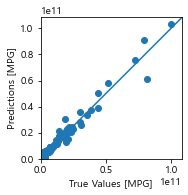

In [15]:
x_preds = []
for i in range(len(models)):
    plt.figure(figsize=(8,12))
    plt.subplot(4, 1, i+1)
    x_pred = models[i].predict(data[i][1]).flatten()
    x_preds.append(x_pred)

    plt.scatter(data[i][3], x_pred)
    plt.xlabel('True Values [MPG]')
    plt.ylabel('Predictions [MPG]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-1e12, 1e12], [-1e12, 1e12])

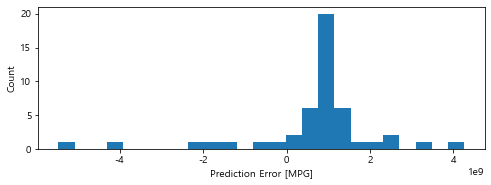

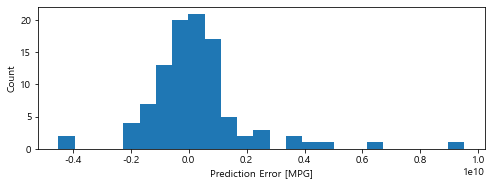

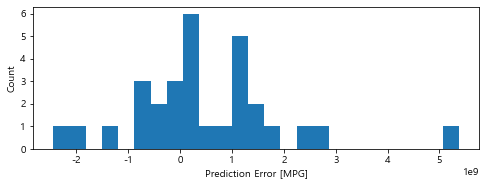

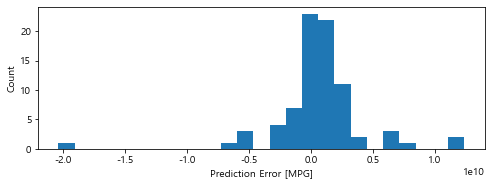

In [16]:
for i in range(len(models)):
    plt.figure(figsize=(8,12))
    plt.subplot(4, 1, i+1)
    error = x_preds[i] - data[i][3]
    plt.hist(error, bins = 25)
    plt.xlabel("Prediction Error [MPG]")
    _ = plt.ylabel("Count")

In [17]:
cols = ['rating_G', 'rating_12', 'rating_15', 'rating_X']
models = {cols[i]: models[i] for i in range(len(models))}
print(models)

{'rating_G': <keras.engine.sequential.Sequential object at 0x000002B91F148D90>, 'rating_12': <keras.engine.sequential.Sequential object at 0x000002B91F2688E0>, 'rating_15': <keras.engine.sequential.Sequential object at 0x000002B91F268A60>, 'rating_X': <keras.engine.sequential.Sequential object at 0x000002B91F28ACD0>}


In [18]:
movie_one_hot.columns

Index(['moviename', 'openingdate', 'attendance', 'screen', 'playcount',
       'director', 'actor', 'openingmonth', 'country_abroad',
       'country_domestic', 'distributor_etc_distributor',
       'distributor_major_abroad', 'distributor_major_domestic',
       'genre_action', 'genre_adventure', 'genre_animation', 'genre_comedy',
       'genre_crime', 'genre_drama', 'genre_etc', 'genre_fantasy',
       'genre_fear', 'genre_mystery', 'genre_romance', 'genre_sf',
       'genre_thriller', 'filmrank_G_rated', 'filmrank_PG 12',
       'filmrank_PG 15', 'filmrank_X_rated', 'sales'],
      dtype='object')

In [19]:
x = movie_one_hot.drop(columns=['moviename', 'openingdate', 'sales'])
y = movie_one_hot['sales']
y = y.to_numpy()

In [20]:
sc = MinMaxScaler()
sc.fit(x)
x_scale = sc.transform(x)
x = pd.DataFrame(data=x_scale, columns=x.columns.tolist())

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [22]:
def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(28,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.1)
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse'])
    
    return model

In [23]:
model = build_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               3712      
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dense_22 (Dense)            (None, 1)                 129       
                                                                 
Total params: 20,353
Trainable params: 20,353
Non-trainable params: 0
_________________________________________________________________


In [24]:
epochs = 2000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    x_train, y_train,
    epochs=epochs, validation_split=0.2, verbose=0,
    callbacks=[early_stop]
)

In [25]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
764,1.908747e+18,854147648.0,1.908747e+18,4.526519e+18,1.085324e+09,4.526519e+18,764
765,1.899362e+18,850262336.0,1.899362e+18,4.494687e+18,1.086676e+09,4.494687e+18,765
766,1.902390e+18,849589120.0,1.902390e+18,4.485151e+18,1.082772e+09,4.485151e+18,766
767,1.886330e+18,848227584.0,1.886330e+18,4.484596e+18,1.081182e+09,4.484596e+18,767
768,1.883210e+18,845081344.0,1.883210e+18,4.527355e+18,1.083367e+09,4.527355e+18,768


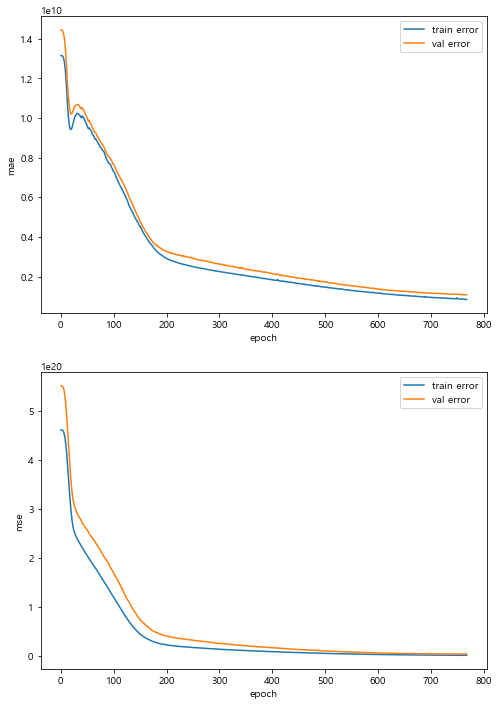

In [26]:
plt.figure(figsize=(8, 12))

plt.subplot(2, 1, 1)
plt.xlabel('epoch')
plt.ylabel('mae')
plt.plot(hist['epoch'], hist['mae'], label='train error')
plt.plot(hist['epoch'], hist['val_mae'], label='val error')
plt.legend()

plt.subplot(2, 1, 2)
plt.xlabel('epoch')
plt.ylabel('mse')
plt.plot(hist['epoch'], hist['mse'], label='train error')
plt.plot(hist['epoch'], hist['val_mse'], label='val error')
plt.legend()

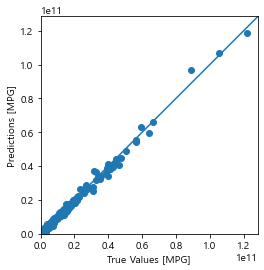

In [27]:
x_pred = model.predict(x_test).flatten()

plt.scatter(y_test, x_pred)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-1e12, 1e12], [-1e12, 1e12])

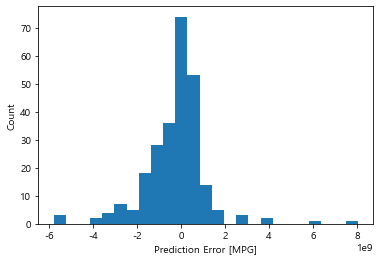

In [28]:
error = x_pred - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

# 예산 데이터가 있는 영화 데이터

## 1. 데이터 불러오기

In [2]:
movie_budget_domestic = pd.read_csv('../data/Budget_Data/Preprocessing_Data/Korea_Data.csv')
movie_budget_abroad = pd.read_csv('../data/Budget_Data/Preprocessing_Data/International_Data.csv')

In [3]:
movie_budget_domestic

,moviename,sales,attendance,budget
0,신과함께,1.026661e+11,12274996.0,4.000000e+10
1,암살,9.846313e+10,12705700.0,1.800000e+10
2,도둑들,9.366481e+10,12983178.0,1.150000e+10
3,설국열차,6.701009e+10,9349993.0,4.370000e+10
4,해적,6.637068e+10,8666046.0,1.340000e+10
5,베를린,5.235557e+10,7166290.0,1.100000e+10
6,군함도,5.050000e+10,6592151.0,3.300000e+10
7,디워,4.933993e+10,7855441.0,3.000000e+10
8,완벽한 타인,4.435081e+10,5293435.0,3.800000e+09
9,좋은놈 나쁜놈 이상한놈,4.374755e+10,6684933.0,1.740000e+10


In [4]:
movie_budget_abroad

,moviename,sales,budget
0,Avatar,3.415079e+12,2.844000e+11
1,Avengers: Endgame,3.357361e+12,4.800000e+11
2,Titanic,2.649584e+12,2.400000e+11
3,Star Wars Ep. VII: The Force Awakens,2.477539e+12,3.672000e+11
4,Avengers: Infinity War,2.458032e+12,3.600000e+11
...,...,...,...
195,The Young and Prodigious T.S. Spivet,4.292244e+08,3.960000e+10
196,Freaks of Nature,8.514960e+07,3.960000e+10
197,George and the Dragon,0.000000e+00,3.840000e+10
198,The Batman,0.000000e+00,1.200000e+11


In [5]:
movie_budget_domestic = movie_budget_domestic.drop(columns=['attendance'])

In [6]:
movie_budget_domestic.head()

,moviename,sales,budget
0,신과함께,1.026661e+11,4.000000e+10
1,암살,9.846313e+10,1.800000e+10
2,도둑들,9.366481e+10,1.150000e+10
3,설국열차,6.701009e+10,4.370000e+10
4,해적,6.637068e+10,1.340000e+10


In [7]:
movie_budget_abroad = movie_budget_abroad[movie_budget_abroad['sales'] != 0]

In [8]:
movie_budget = pd.concat([movie_budget_domestic, movie_budget_abroad], axis=0)
movie_budget

,moviename,sales,budget
0,신과함께,1.026661e+11,4.000000e+10
1,암살,9.846313e+10,1.800000e+10
2,도둑들,9.366481e+10,1.150000e+10
3,설국열차,6.701009e+10,4.370000e+10
4,해적,6.637068e+10,1.340000e+10
...,...,...,...
192,Bogus,5.228887e+09,3.840000e+10
193,Cats Don't Dance,4.306322e+09,3.840000e+10
194,Cradle Will Rock,3.479964e+09,3.840000e+10
195,The Young and Prodigious T.S. Spivet,4.292244e+08,3.960000e+10


In [9]:
movie_budget.reset_index(inplace=True, drop=True)
movie_budget

,moviename,sales,budget
0,신과함께,1.026661e+11,4.000000e+10
1,암살,9.846313e+10,1.800000e+10
2,도둑들,9.366481e+10,1.150000e+10
3,설국열차,6.701009e+10,4.370000e+10
4,해적,6.637068e+10,1.340000e+10
...,...,...,...
222,Bogus,5.228887e+09,3.840000e+10
223,Cats Don't Dance,4.306322e+09,3.840000e+10
224,Cradle Will Rock,3.479964e+09,3.840000e+10
225,The Young and Prodigious T.S. Spivet,4.292244e+08,3.960000e+10


In [123]:
sales_x = movie_budget['sales']
sales_x = sales_x.to_numpy()
sales_y = movie_budget['budget']
sales_y = sales_y.to_numpy()

In [124]:
sc = MinMaxScaler()

sales_x = sales_x.reshape(-1, 1)
sc.fit(sales_x)
sales_x = sc.transform(sales_x).reshape(-1)

In [125]:
sales_x_train, sales_x_test, sales_y_train, sales_y_test = train_test_split(sales_x, sales_y,
                                                                            random_state=42)

In [126]:
def build_model():
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=(1,)),
        layers.Dense(256, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.1)
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse'])
    
    return model

In [127]:
sales_model = build_model()
sales_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 256)               512       
                                                                 
 dense_41 (Dense)            (None, 256)               65792     
                                                                 
 dense_42 (Dense)            (None, 1)                 257       
                                                                 
Total params: 66,561
Trainable params: 66,561
Non-trainable params: 0
_________________________________________________________________


In [128]:
epochs = 2000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

sales_history = sales_model.fit(
    sales_x_train, sales_y_train,
    epochs=epochs, validation_split=0.2, verbose=0,
    callbacks=[early_stop]
)

In [129]:
sales_hist = pd.DataFrame(sales_history.history)
sales_hist['epoch'] = sales_history.epoch
sales_hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
1269,3.686994e+21,4.613054e+10,3.686994e+21,3.810374e+21,4.314639e+10,3.810374e+21,1269
1270,3.686838e+21,4.612914e+10,3.686838e+21,3.808212e+21,4.313802e+10,3.808212e+21,1270
1271,3.686422e+21,4.612855e+10,3.686422e+21,3.809196e+21,4.313920e+10,3.809196e+21,1271
1272,3.686189e+21,4.612762e+10,3.686189e+21,3.809469e+21,4.313689e+10,3.809469e+21,1272
1273,3.686150e+21,4.612580e+10,3.686150e+21,3.807404e+21,4.312868e+10,3.807404e+21,1273


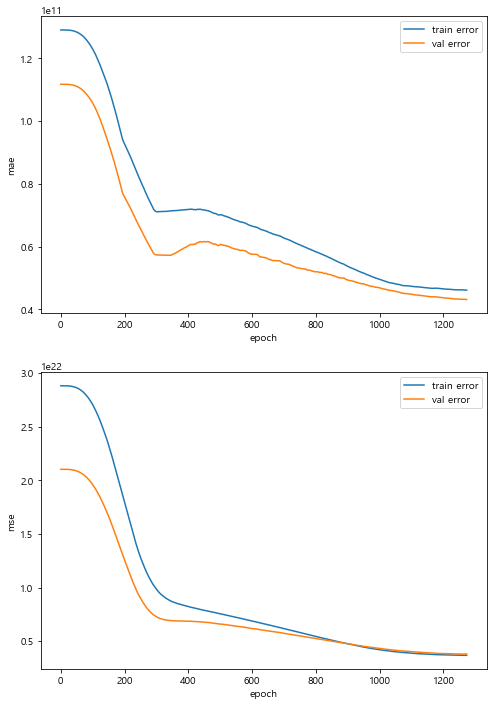

In [130]:
plt.figure(figsize=(8, 12))

plt.subplot(2, 1, 1)
plt.xlabel('epoch')
plt.ylabel('mae')
plt.plot(sales_hist['epoch'], sales_hist['mae'], label='train error')
plt.plot(sales_hist['epoch'], sales_hist['val_mae'], label='val error')
plt.legend()

plt.subplot(2, 1, 2)
plt.xlabel('epoch')
plt.ylabel('mse')
plt.plot(sales_hist['epoch'], sales_hist['mse'], label='train error')
plt.plot(sales_hist['epoch'], sales_hist['val_mse'], label='val error')
plt.legend()

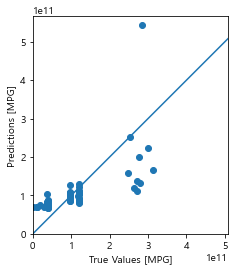

In [131]:
sales_x_pred = sales_model.predict(sales_x_test).flatten()

plt.scatter(sales_y_test, sales_x_pred)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-1e12, 1e12], [-1e12, 1e12])

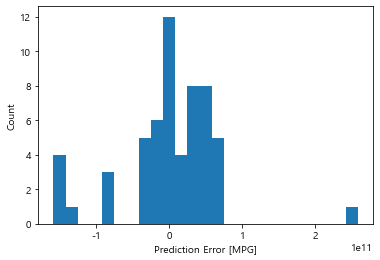

In [132]:
error = sales_x_pred - sales_y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")